<a href="https://colab.research.google.com/github/AlexanderPirogovID/Machine-Learning/blob/main/FRI_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import io
from google.colab import files

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
%pip install kaggle

In [ ]:
import ipywidgets as widgets
import os

def get_and_store_secret(placeholder, output_secret_path):
  password_field = widgets.Password(
      description=f"Enter Key:",
      placeholder=placeholder,
      disabled=False
  )

  output = widgets.Output()

  def on_button_click(b):
    with output:
      token = password_field.value
      with open(os.path.expanduser(output_secret_path), "w") as f:
        f.write(token)
      password_field.close()
      button.close()

  button = widgets.Button(description="Save Key")
  button.on_click(on_button_click)

  display(password_field, button, output)

In [ ]:
kaggle_user_path = os.path.expanduser("~/.cache/kaggle-user.txt")
get_and_store_secret("KAGGLE_USERNAME", kaggle_user_path)

In [ ]:
kaggle_key_path = os.path.expanduser("~/.cache/kaggle.token")
get_and_store_secret("KAGGLE_KEY", kaggle_key_path)

In [ ]:
with open(kaggle_user_path) as f:
    os.environ["KAGGLE_USERNAME"] = f.read().strip()

with open(kaggle_key_path) as f:
    os.environ["KAGGLE_KEY"] = f.read().strip()

In [ ]:
%pip install kagglehub[pandas-datasets]

In [ ]:
!kaggle datasets download -d tsiaras/uk-road-safety-accidents-and-vehicles

In [ ]:
!unzip uk-road-safety-accidents-and-vehicles.zip

In [3]:
uploaded = files.upload()

filename = next(iter(uploaded))

df = pd.read_csv(io.BytesIO(uploaded[filename]), nrows=50000, low_memory=False)

print(f"Загружено строк: {df.shape[0]}, колонок: {df.shape[1]}")

Saving Accident_Information.csv to Accident_Information.csv
Загружено строк: 50000, колонок: 34


In [4]:
# Генерация ошибок

df_broken = df.copy()

def corrupt_speed(val):
    if np.random.random() < 0.1: # 10% пропусков
        return np.nan
    if np.random.random() < 0.05: # 5% явного мусора
        return "error_reading"
    return f"{int(val)} mph"

df_broken['Speed_limit_Raw'] = df_broken['Speed_limit'].apply(corrupt_speed)
df_broken.drop('Speed_limit', axis=1, inplace=True)

mask_null_lat = np.random.choice([True, False], size=len(df_broken), p=[0.15, 0.85])
df_broken.loc[mask_null_lat, 'Latitude'] = np.nan

mask_outlier = np.random.choice([True, False], size=len(df_broken), p=[0.02, 0.98])
df_broken.loc[mask_outlier, 'Latitude'] = 200.0 # Нереальная координата

mask_null_road = np.random.choice([True, False], size=len(df_broken), p=[0.1, 0.9])
df_broken.loc[mask_null_road, 'Road_Surface_Conditions'] = np.nan

print("Данные успешно испорчены. Пример испорченной колонки скорости:")
print(df_broken['Speed_limit_Raw'].head(10))

Данные успешно испорчены. Пример испорченной колонки скорости:
0    30 mph
1    30 mph
2    30 mph
3    30 mph
4    30 mph
5    30 mph
6    30 mph
7    30 mph
8    30 mph
9    30 mph
Name: Speed_limit_Raw, dtype: object


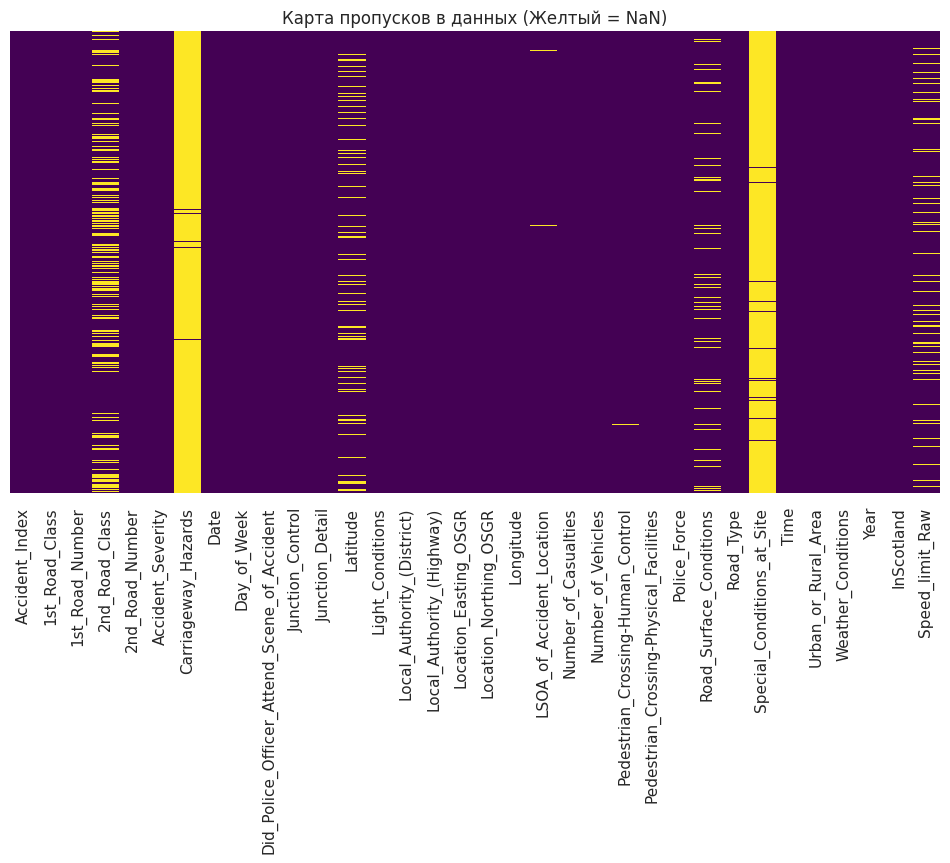

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Accident_Index                               50000 non-null  object 
 1   1st_Road_Class                               50000 non-null  object 
 2   1st_Road_Number                              50000 non-null  int64  
 3   2nd_Road_Class                               34407 non-null  object 
 4   2nd_Road_Number                              49903 non-null  float64
 5   Accident_Severity                            50000 non-null  object 
 6   Carriageway_Hazards                          642 non-null    object 
 7   Date                                         50000 non-null  object 
 8   Day_of_Week                                  50000 non-null  object 
 9   Did_Police_Officer_Attend_Scene_of_Accident  49990 non-null  float64
 10

In [5]:
# Визуализация проблем

plt.figure(figsize=(12, 6))
sns.heatmap(df_broken.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Карта пропусков в данных (Желтый = NaN)')
plt.show()

print(df_broken.info())

In [6]:
print("\nШаг 4.1: Очистка строковых значений в числа")

def clean_speed_limit(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    # Если есть "error", возвращаем NaN
    if "error" in val:
        return np.nan
    # Удаляем все нечисловые символы кроме точки
    import re
    num = re.findall(r"[-+]?\d*\.\d+|\d+", val)
    if num:
        return float(num[0])
    return np.nan

df_broken['Speed_limit_Clean'] = df_broken['Speed_limit_Raw'].apply(clean_speed_limit)

print("Пример после очистки скорости:")
print(df_broken[['Speed_limit_Raw', 'Speed_limit_Clean']].head())


Шаг 4.1: Очистка строковых значений в числа
Пример после очистки скорости:
  Speed_limit_Raw  Speed_limit_Clean
0          30 mph               30.0
1          30 mph               30.0
2          30 mph               30.0
3          30 mph               30.0
4          30 mph               30.0


In [7]:
def clean_speed_limit(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    if "error" in val:
        return np.nan
    import re
    num = re.findall(r"[-+]?\d*\.\d+|\d+", val)
    if num:
        return float(num[0])
    return np.nan

df_broken['Speed_limit_Clean'] = df_broken['Speed_limit_Raw'].apply(clean_speed_limit)

print("Пример после очистки скорости:")
print(df_broken[['Speed_limit_Raw', 'Speed_limit_Clean']].head())

Пример после очистки скорости:
  Speed_limit_Raw  Speed_limit_Clean
0          30 mph               30.0
1          30 mph               30.0
2          30 mph               30.0
3          30 mph               30.0
4          30 mph               30.0


In [8]:
outlier_mask = (df_broken['Latitude'] > 61) | (df_broken['Latitude'] < 49)
print(f"Найдено выбросов по координатам: {outlier_mask.sum()}")
df_broken.loc[outlier_mask, 'Latitude'] = np.nan

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_cols = ['Latitude', 'Longitude', 'Speed_limit_Clean']
df_broken[num_cols] = num_imputer.fit_transform(df_broken[num_cols])

cat_cols = ['Road_Surface_Conditions', 'Weather_Conditions']
df_broken[cat_cols] = cat_imputer.fit_transform(df_broken[cat_cols])

print("Пропуски после обработки:")
print(df_broken[num_cols + cat_cols].isnull().sum())

Найдено выбросов по координатам: 948
Пропуски после обработки:
Latitude                   0
Longitude                  0
Speed_limit_Clean          0
Road_Surface_Conditions    0
Weather_Conditions         0
dtype: int64


In [9]:
df_broken['Date'] = pd.to_datetime(df_broken['Date'], format='%Y-%m-%d', errors='coerce')

df_broken['Month'] = df_broken['Date'].dt.month
df_broken['DayOfWeek'] = df_broken['Date'].dt.dayofweek
df_broken['Hour'] = pd.to_datetime(df_broken['Time'], format='%H:%M', errors='coerce').dt.hour

df_broken['Hour'] = df_broken['Hour'].fillna(df_broken['Hour'].mode()[0])

print(df_broken[['Date', 'Month', 'Hour']].head())

        Date  Month  Hour
0 2005-01-04      1  17.0
1 2005-01-05      1  17.0
2 2005-01-06      1   0.0
3 2005-01-07      1  10.0
4 2005-01-10      1  21.0


In [ ]:
'''
le = LabelEncoder()
cols_to_encode = ['Road_Surface_Conditions', 'Weather_Conditions', 'Urban_or_Rural_Area']

for col in cols_to_encode:
    df_broken[col] = df_broken[col].astype(str)
    df_broken[col] = le.fit_transform(df_broken[col])

print(df_broken[cols_to_encode].head())
'''

In [10]:
categorical_cols_for_ohe = [
    'Accident_Severity',
    '1st_Road_Class',
    '2nd_Road_Class',
    'Light_Conditions',
    'Road_Surface_Conditions',
    'Weather_Conditions',
    'Urban_or_Rural_Area',
    'Road_Type',
    'Junction_Control',
    'Junction_Detail',
    'Special_Conditions_at_Site',
    'Carriageway_Hazards'
]

for col in categorical_cols_for_ohe:
    if col in df_broken.columns:
        df_broken[col] = df_broken[col].fillna('Unknown').astype(str)
    else:
        print(f"Столбец {col} не найден в текущем DataFrame")

print(f"Количество колонок до OHE: {df_broken.shape[1]}")


df_broken = pd.get_dummies(df_broken,
                          columns=categorical_cols_for_ohe,
                          prefix=categorical_cols_for_ohe,
                          drop_first=False)

print(f"Количество колонок после OHE: {df_broken.shape[1]}")
print("Фрагмент новых столбцов OHE:")


ohe_sample_cols = [col for col in df_broken.columns if 'Accident_Severity_' in col or '1st_Road_Class_' in col]
print(df_broken[ohe_sample_cols].head())

print("\nФинальное количество столбцов, готовых к модели:")
print(df_broken.shape)

Количество колонок до OHE: 38
Количество колонок после OHE: 102
Фрагмент новых столбцов OHE:
   Accident_Severity_Fatal  Accident_Severity_Serious  \
0                    False                       True   
1                    False                      False   
2                    False                      False   
3                    False                      False   
4                    False                      False   

   Accident_Severity_Slight  1st_Road_Class_A  1st_Road_Class_A(M)  \
0                     False              True                False   
1                      True             False                False   
2                      True             False                False   
3                      True              True                False   
4                      True             False                False   

   1st_Road_Class_B  1st_Road_Class_C  1st_Road_Class_Motorway  \
0             False             False                    False   
1          

In [11]:
scaler = MinMaxScaler()
scale_cols = ['Latitude', 'Longitude', 'Speed_limit_Clean', 'Hour']

df_broken[scale_cols] = scaler.fit_transform(df_broken[scale_cols])

print("Данные после нормализации (от 0 до 1):")
print(df_broken[scale_cols].head())

Данные после нормализации (от 0 до 1):
   Latitude  Longitude  Speed_limit_Clean      Hour
0  0.053216   0.873967           0.333333  0.739130
1  0.061458   0.868706           0.333333  0.739130
2  0.084767   0.870051           0.333333  0.000000
3  0.051446   0.878401           0.333333  0.434783
4  0.054987   0.882819           0.333333  0.913043


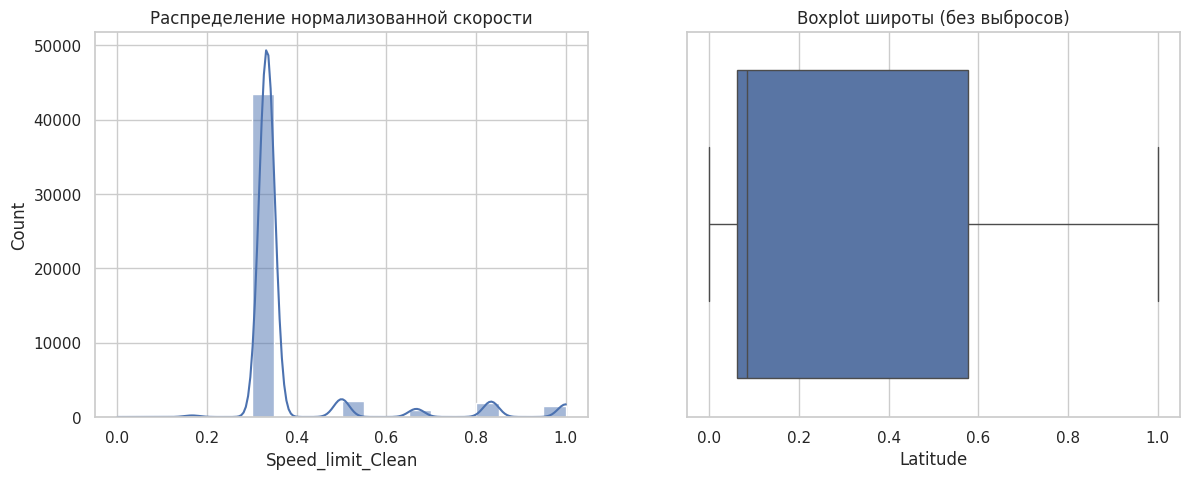

Готовый к обучению датасет:
  Accident_Index  1st_Road_Number  2nd_Road_Number       Date Day_of_Week  \
0  200501BS00001             3218              0.0 2005-01-04     Tuesday   
1  200501BS00002              450              0.0 2005-01-05   Wednesday   
2  200501BS00003                0              0.0 2005-01-06    Thursday   
3  200501BS00004             3220              0.0 2005-01-07      Friday   
4  200501BS00005                0              0.0 2005-01-10      Monday   

   Did_Police_Officer_Attend_Scene_of_Accident  Latitude  \
0                                          1.0  0.053216   
1                                          1.0  0.061458   
2                                          1.0  0.084767   
3                                          1.0  0.051446   
4                                          1.0  0.054987   

  Local_Authority_(District) Local_Authority_(Highway)  Location_Easting_OSGR  \
0     Kensington and Chelsea    Kensington and Chelsea             

In [12]:
# Итоговая проверка

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_broken['Speed_limit_Clean'], bins=20, kde=True)
plt.title('Распределение нормализованной скорости')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_broken['Latitude'])
plt.title('Boxplot широты (без выбросов)')

plt.show()

print("Готовый к обучению датасет:")
print(df_broken.head())